# 线性回归的从零开始实现
:label:`sec_linear_scratch`

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，(**我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。
在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。


In [34]:
%matplotlib inline
import random
import torch
from myd2l import torch as d2l

## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是*使用这个有限样本的数据集*来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。


In [35]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(mean=0,  std=1.0, size=(num_examples, len(w))) # 正态分布，均值位0，标准差为1，形状为(num_examples, len(w))的数据组
    y = torch.matmul(X, w) + b #表示对输入特征矩阵 X（形状 (n, d)）和权重向量 w（形状 (d,m)）进行矩阵乘法，得到每个样本的线性组合结果（形状 (n,m)），再加上偏置项 b（标量，通过广播加到每个样本上）。
    y += torch.normal(0, 0.01, size=y.shape) # 线性的基础上加入Gauss噪声
    return X, y.reshape((-1, 1)) 
    # 通过 y.reshape((-1, 1)) 将 y 变成 (n, 1)
    # -1 表示“自动推断该维度的大小”，使得总元素数量不变。

In [52]:
true_w = torch.tensor([2, -3.4])
print(true_w.size())
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([2])


注意，[**`features`中的每一行都包含一个二维数据样本，即 1000\*2的tensor
`labels`中的每一行都包含一维标签值（一个标量），即 1000\*1的tensor**]。


In [37]:
print('features:', features[0],'\nlabel:', labels[0]) #打印其中第0个数据

features: tensor([-0.0932,  0.6530]) 
label: tensor([1.8016])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


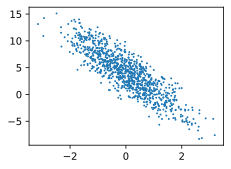

In [53]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1); 
# features[:, 1] 结果是一个 一维张量，形状为 (n,)
# .detach() 断开与计算图的连接，得到一个“干净”的张量（即使原张量有梯度也不影响）
# .numpy() 转为 NumPy 数组，供 Matplotlib 使用
# 最佳实践：只要要把 PyTorch 张量传给 Matplotlib / NumPy / OpenCV 等库，一律先 .detach().cpu().numpy()

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。


In [39]:
def data_iter(batch_size, features, labels): #加入batch size作为小批量随机梯度下降的超参数hyperparameter
    num_examples = len(features) #已经定义了feature 是（1000,2）格式的data ,len()是取其第一维度的长度
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # range(start, stop, step) 以batch_size对数据进行切割，i 是每一块的起始索引。
        batch_indices = torch.tensor(   
            indices[i: min(i + batch_size, num_examples)]) # min(...) 确保不会越界（最后一块可能不足 batch_size）
        yield features[batch_indices], labels[batch_indices] #yield：使函数成为生成器（generator），每次调用返回一个批次，不一次性加载全部数据（节省内存）

        #生成大小为`batch_size`的小批量 feature和labels
        # 进行遍历整个dataset

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。
每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。
GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。
每个批量的特征维度显示批量大小和输入特征数。
同样的，批量的标签形状与`batch_size`相等。


In [40]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break # 如果不break会直接遍历整个dataset

tensor([[ 0.8732,  1.3097],
        [ 0.2162, -2.1549],
        [ 0.3887, -0.6766],
        [-1.6909, -0.2243],
        [ 0.3980,  0.0674],
        [-0.0073,  0.3208],
        [ 0.6407,  0.4202],
        [ 0.0489, -0.5329],
        [ 1.3374, -0.0288],
        [-1.0653,  0.5957]]) 
 tensor([[ 1.4870],
        [11.9481],
        [ 7.2745],
        [ 1.5893],
        [ 4.7675],
        [ 3.0923],
        [ 4.0443],
        [ 6.1044],
        [ 6.9767],
        [ 0.0353]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，**它要求我们将所有数据加载到内存中，并执行大量的随机内存访问**。
在深度学习框架中实现的内置迭代器效率要高得多，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

[**在我们开始用小批量随机梯度下降优化我们的模型参数之前**]，
(**我们需要先有一些参数**)。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。


In [41]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) #默认为false
# 它生成的是一个张量，其中每个元素都是从指定正态分布中独立采样的一个随机值（即多个样本）
# 从均值为 0、标准差为 0.01 的正态分布中，独立采样 2 个数，结果是一个 (2, 1) 的张量
# torch.normal(...) 是从这个模型中抽样，得到具体数值
# size=(3,5)会从正态分布独立抽取 15 个随机样本，并把它们组织成一个形状为 (3, 5) 的张量。
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用 :numref:`sec_autograd`中引入的自动微分来计算梯度。

## 定义模型

接下来，我们必须[**定义模型，将模型的输入和参数同模型的输出关联起来。**]
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下 :numref:`subsec_broadcasting`中描述的**广播机制**：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。


In [42]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## [**定义损失函数**]

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用 :numref:`sec_linear_regression`中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。


In [43]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## (**定义优化算法**)

正如我们在 :numref:`sec_linear_regression`中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。


In [44]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降
    params ： 传入的参数，在本例子中为 w和b
    lr： learning rate 学习率 手动指定的超参数，不更新
    batch_size : 批大小 手动指定的超参数，不更新
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size 
            # 注意理论推导中的批处理平均定义在MSE里；
            # 代码上，由于定义MSE时，还没有定义batch_size，所以在此处添加
            param.grad.zero_() # 每计算一次梯度都将本轮的梯度归零，因为参数已经更新，梯度值已经发生变化
            # 又因为torch中梯度的累加原则，不归零会导致多次梯度累加，梯度值错误

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在 :numref:`chap_optimization`中详细介绍。


In [45]:
lr = 0.03
num_epochs = 3 #指把整个数据扫3边 
# epoch 定义：当一个完整的数据集通过了神经网络一次并且返回了一次，这个过程称为一次>epoch。（也就是说，所有训练样本在神经网络中都 进行了一次正向传播 和一次反向传播 ）
# 再通俗一点，一个Epoch就是将所有训练样本训练一次的过程。
net = linreg #单 全连接层的神经网络
loss = squared_loss

In [46]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数，由于有两个参数，因此传入的是参数的list
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}') # .mean()手动除以了 batch_size,在前面计算梯度时已经在batch内进行了累加

epoch 1, loss 0.029466
epoch 2, loss 0.000105
epoch 3, loss 0.000051


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。
事实上，真实参数和通过训练学到的参数确实非常接近。


In [28]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0009, 0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
1. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？


[Discussions](https://discuss.d2l.ai/t/1778)


# Question :计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
---

Answer: 
计算二阶导数（Hessian 矩阵或高阶梯度）在深度学习和优化中非常重要，例如用于牛顿法、曲率分析、不确定性估计等。然而，在实际计算中会遇到多个**理论、数值和计算效率**方面的问题。下面我们系统地分析这些问题及其解决方案。

---

## 🔍 一、主要问题

### 1. **计算复杂度高（维度灾难）**
- **问题**：  
  对于参数向量 $\theta \in \mathbb{R}^d$，其 Hessian 矩阵是 $d \times d$ 的。
  - 存储 Hessian 需要 $O(d^2)$ 内存
  - 计算完整 Hessian 需要 $O(d^2)$ 次梯度计算（或自动微分操作）
  - 当 $d = 10^6$（常见于神经网络），Hessian 有 $10^{12}$ 个元素，无法存储或计算

- **后果**：  
  在大规模模型中，**显式计算完整二阶导数不可行**。

---

### 2. **数值不稳定（浮点误差放大）**
- **问题**：  
  二阶导数是“导数的导数”，对数值噪声极其敏感。
  - 一阶梯度本身已有舍入误差
  - 对有噪声的梯度再求导 → 误差被显著放大
  - 尤其在使用有限差分（finite difference）近似时更严重：
    $$
    \frac{\partial^2 f}{\partial x^2} \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}
    $$
    当 $h$ 太小 → 舍入误差主导；$h$ 太大 → 截断误差主导

- **后果**：  
  Hessian 可能非对称、非正定，甚至包含 NaN 或无穷大。

---

### 3. **自动微分支持有限**
- **问题**：  
  虽然 PyTorch/TensorFlow 支持高阶导数（如 `torch.autograd.grad` 嵌套），但：
  - 并非所有操作都支持二阶导（如某些自定义 CUDA 算子）
  - 控制流（if/while）可能导致高阶梯度不连续
  - 高阶导数的计算图更复杂，容易出错

- **示例错误**：
  ```python
  y = model(x)
  grad = torch.autograd.grad(y, w, create_graph=True)[0]
  hessian = torch.autograd.grad(grad.sum(), w)  # 可能失败
  ```

---

### 4. **Hessian 可能病态（ill-conditioned）**
- **问题**：  
  Hessian 的条件数（最大特征值 / 最小特征值）可能极大。
  - 导致牛顿法方向不稳定
  - 特征值接近零 → 逆 Hessian 不存在或数值爆炸

- **原因**：  
  - 参数尺度不一致（如一个权重是 0.001，另一个是 1000）
  - 模型过参数化（如神经网络存在大量冗余方向）

---

### 5. **内存消耗大（计算图保留）**
- **问题**：  
  计算二阶导数需要保留一阶梯度的计算图：
  ```python
  grad = torch.autograd.grad(loss, w, create_graph=True)  # 必须设 create_graph=True
  ```
  - 这会导致**整个前向+一阶反向的计算图被保留**
  - 内存占用远高于一阶训练

- **后果**：  
  即使模型能跑一阶 SGD，也可能因内存不足无法计算二阶导。

---

## 🛠️ 二、解决方案

### ✅ 1. **避免显式计算完整 Hessian → 使用近似方法**

| 方法 | 原理 | 优点 |
|------|------|------|
| **Hessian-vector product (HVP)** | 只计算 $Hv$（$v$ 是任意向量），无需构造 $H$ | 内存 $O(d)$，可用共轭梯度法求解牛顿步 |
| **Fisher Information Matrix (FIM)** | 用 Fisher 信息矩阵近似 Hessian（在概率模型中） | 正定、更稳定，常用于自然梯度 |
| **K-FAC / KFRA** | 对 Hessian 做 Kronecker 因式分解近似 | 适用于全连接/卷积层，大幅降低计算量 |
| **随机 Hessian 估计** | 用子采样数据估计 Hessian | 类似 mini-batch，降低方差 |

> 💡 PyTorch 示例（HVP）：
> ```python
> def hvp(loss, params, v):
>     grad = torch.autograd.grad(loss, params, create_graph=True)
>     Hv = torch.autograd.grad(grad, params, grad_outputs=v)
>     return Hv
> ```

---

### ✅ 2. **数值稳定性改进**

- **使用自动微分而非有限差分**：  
  自动微分无截断误差，精度更高。
  
- **梯度平滑**：  
  对损失函数加小扰动或使用平滑激活函数（如 GELU 替代 ReLU）。

- **特征缩放**：  
  标准化输入和参数，使 Hessian 条件数改善。

---

### ✅ 3. **高效算法与库支持**

- **使用专用库**：
  - [`torch.func`](https://pytorch.org/functorch/stable/)（PyTorch 的 functorch）提供高效高阶导
  - [`JAX`](https://jax.readthedocs.io/) 原生支持任意阶导数，且编译优化好
  - [`BackPACK`](https://backpack.pt/) 扩展 PyTorch，高效计算 Hessian 近似

- **牛顿法变种**：
  - **拟牛顿法（L-BFGS）**：用低秩矩阵近似 Hessian 逆，只需一阶梯度
  - **Hessian-free optimization**：用共轭梯度法隐式求解牛顿方程，无需显式 Hessian

---

### ✅ 4. **内存优化技巧**

- **检查点（Checkpointing）**：  
  重计算部分前向传播以节省内存（牺牲时间换空间）

- **分块计算**：  
  将参数分组，逐块计算 Hessian 子矩阵

- **关闭不必要的梯度**：
  ```python
  with torch.no_grad():
      # 不需要梯度的部分
  ```

---

### ✅ 5. **正则化 Hessian**

- **加 Levenberg-Marquardt 项**：
  $$
  H_{\text{reg}} = H + \lambda I
  $$
  保证正定性，避免奇异。

- **截断负特征值**：  
  在特征分解后，将负特征值设为小正数。

---

## ✅ 总结：何时用二阶导？如何安全使用？

| 场景 | 建议 |
|------|------|
| **大规模神经网络训练** | ❌ 避免完整 Hessian；✅ 用 L-BFGS 或一阶方法 |
| **小模型/凸优化** | ✅ 可计算完整 Hessian（如逻辑回归） |
| **不确定性量化** | ✅ 用 Laplace 近似 + Hessian（但需正则化） |
| **曲率分析/可视化** | ✅ 用 HVP 计算主曲率方向 |

> 🎯 **黄金法则**：  
> **除非必要，否则不要显式计算完整二阶导数。优先使用 Hessian-vector products 或拟牛顿近似。**

---

通过结合**近似算法、数值稳定技巧和高效库**，我们可以在大多数实际场景中安全、高效地利用二阶信息，同时规避其固有缺陷。